In [111]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as missing
import warnings
import matplotlib.pyplot as plt

from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report


warnings.filterwarnings('ignore')

print("scikit-learn version:", sklearn.__version__)     # 1.1.3
print("pandas version:", pd.__version__)            # 1.5.1
print("seaborn version:", sns.__version__)   

df1 = pd.read_csv("./transform_dataset.csv", index_col=0)
print(df1.shape)

scikit-learn version: 1.3.1
pandas version: 2.1.1
seaborn version: 0.13.0
(179638, 9)


In [112]:
df1 = df1.reset_index()[['idll_vo3lv', 'timestamp', 'numbercl', 'patternsm', 'statuscl', 'timestampcl', 'timestampload', 'timestampsm','score']]	



In [113]:
selected_columns = df1[['idll_vo3lv', 'timestampcl']]
selected_columns

,idll_vo3lv,timestampcl
0,1,"1583742751461,1583742751869"
1,1,"1583742753766,1583742754238"
2,1,"1583742756412,1583742756876"
3,1,"1583742759029,1583742759476"
4,1,"1583742761381,1583742762222"
...,...,...
179633,10058,"1607080545280,1607080545718"
179634,10058,"1607080547519,1607080548139"
179635,10058,"1607080549806,1607080550351"
179636,10058,"1607080552454,1607080553061"


In [114]:
# Splitting the 'timestampcl' column and exploding the values into rows
selected_columns['timestampcl'] = selected_columns['timestampcl'].str.split(',')
selected_columns = selected_columns.explode('timestampcl')



# Resetting index if needed
selected_columns.reset_index(drop=True, inplace=True)

selected_columns


,idll_vo3lv,timestampcl
0,1,1583742751461
1,1,1583742751869
2,1,1583742753766
3,1,1583742754238
4,1,1583742756412
...,...,...
568315,10058,1607080549806
568316,10058,1607080550351
568317,10058,1607080552454
568318,10058,1607080553061


In [115]:
# Convert 'timestampcl' to numeric (considering NaN as missing values)
selected_columns['timestampcl'] = pd.to_numeric(selected_columns['timestampcl'], errors='coerce')

# Convert milliseconds to seconds
selected_columns['timestampcl'] = pd.to_datetime(selected_columns['timestampcl'], unit='ms', errors='coerce')

selected_columns

,idll_vo3lv,timestampcl
0,1,2020-03-09 08:32:31.460999936
1,1,2020-03-09 08:32:31.868999936
2,1,2020-03-09 08:32:33.766000128
3,1,2020-03-09 08:32:34.238000128
4,1,2020-03-09 08:32:36.412000000
...,...,...
568315,10058,2020-12-04 11:15:49.806000128
568316,10058,2020-12-04 11:15:50.351000064
568317,10058,2020-12-04 11:15:52.454000128
568318,10058,2020-12-04 11:15:53.060999936


In [116]:
# Convert 'timestampcl' to datetime
selected_columns['timestampcl'] = pd.to_datetime(selected_columns['timestampcl'], errors='coerce')

# Group by 'idll_vo3lv' and calculate time differences in seconds
selected_columns['time_diff_seconds'] = selected_columns.groupby('idll_vo3lv')['timestampcl'].diff().dt.total_seconds()

selected_columns


,idll_vo3lv,timestampcl,time_diff_seconds
0,1,2020-03-09 08:32:31.460999936,NaN
1,1,2020-03-09 08:32:31.868999936,0.408
2,1,2020-03-09 08:32:33.766000128,1.897
3,1,2020-03-09 08:32:34.238000128,0.472
4,1,2020-03-09 08:32:36.412000000,2.174
...,...,...,...
568315,10058,2020-12-04 11:15:49.806000128,1.667
568316,10058,2020-12-04 11:15:50.351000064,0.545
568317,10058,2020-12-04 11:15:52.454000128,2.103
568318,10058,2020-12-04 11:15:53.060999936,0.607


In [117]:
# Calculate the average clicking speed for each 'idll_vo3lv'
avg_clicking_speed = selected_columns.groupby('idll_vo3lv')['time_diff_seconds'].mean().reset_index()
avg_clicking_speed.rename(columns={'time_diff_seconds': 'avg_clicking_speed_sec'}, inplace=True)
# Display the average clicking speed for each 'idll_vo3lv'
avg_clicking_speed


,idll_vo3lv,avg_clicking_speed_sec
0,1,1.195667
1,2,1.764778
2,3,1.212054
3,4,1.064324
4,5,1.147891
...,...,...
4543,10052,1.820186
4544,10054,0.623714
4545,10055,6.478500
4546,10056,5.424182


In [118]:
df1 = df1.merge(avg_clicking_speed, on='idll_vo3lv')
df1


,idll_vo3lv,timestamp,numbercl,patternsm,statuscl,timestampcl,timestampload,timestampsm,score,avg_clicking_speed_sec
0,1,2020-03-09 09:32:32,"3,7","0,0,1,0,0,0,1,0","1,1","1583742751461,1583742751869",2020-03-09 08:31:53.856000,2520,6,1.195667
1,1,2020-03-09 09:32:35,"2,1","1,1,0,0,0,0,0,0","1,1","1583742753766,1583742754238",2020-03-09 08:31:53.856000,2576,6,1.195667
2,1,2020-03-09 09:32:37,"3,4","0,0,1,1,0,0,0,0","1,1","1583742756412,1583742756876",2020-03-09 08:31:53.856000,2541,6,1.195667
3,1,2020-03-09 09:32:40,"8,6","0,0,0,0,0,1,0,1","1,1","1583742759029,1583742759476",2020-03-09 08:31:53.856000,2540,6,1.195667
4,1,2020-03-09 09:32:42,"4,3","0,0,1,1,0,0,0,0","1,1","1583742761381,1583742762222",2020-03-09 08:31:53.856000,2384,6,1.195667
...,...,...,...,...,...,...,...,...,...,...
179633,10058,2020-12-04 12:15:48,"1,6","1,0,0,0,0,1,0,0","1,1","1607080545280,1607080545718",2020-12-04 11:16:47.744000,2170,51,1.004269
179634,10058,2020-12-04 12:15:51,"1,5","1,0,0,0,1,0,0,0","1,1","1607080547519,1607080548139",2020-12-04 11:16:47.744000,2113,51,1.004269
179635,10058,2020-12-04 12:15:53,"3,8","0,0,1,0,0,0,0,1","1,1","1607080549806,1607080550351",2020-12-04 11:16:47.744000,1529,51,1.004269
179636,10058,2020-12-04 12:15:56,"3,7","0,0,1,0,0,0,1,0","1,1","1607080552454,1607080553061",2020-12-04 11:16:47.744000,2566,51,1.004269


In [119]:
df1

,idll_vo3lv,timestamp,numbercl,patternsm,statuscl,timestampcl,timestampload,timestampsm,score,avg_clicking_speed_sec
0,1,2020-03-09 09:32:32,"3,7","0,0,1,0,0,0,1,0","1,1","1583742751461,1583742751869",2020-03-09 08:31:53.856000,2520,6,1.195667
1,1,2020-03-09 09:32:35,"2,1","1,1,0,0,0,0,0,0","1,1","1583742753766,1583742754238",2020-03-09 08:31:53.856000,2576,6,1.195667
2,1,2020-03-09 09:32:37,"3,4","0,0,1,1,0,0,0,0","1,1","1583742756412,1583742756876",2020-03-09 08:31:53.856000,2541,6,1.195667
3,1,2020-03-09 09:32:40,"8,6","0,0,0,0,0,1,0,1","1,1","1583742759029,1583742759476",2020-03-09 08:31:53.856000,2540,6,1.195667
4,1,2020-03-09 09:32:42,"4,3","0,0,1,1,0,0,0,0","1,1","1583742761381,1583742762222",2020-03-09 08:31:53.856000,2384,6,1.195667
...,...,...,...,...,...,...,...,...,...,...
179633,10058,2020-12-04 12:15:48,"1,6","1,0,0,0,0,1,0,0","1,1","1607080545280,1607080545718",2020-12-04 11:16:47.744000,2170,51,1.004269
179634,10058,2020-12-04 12:15:51,"1,5","1,0,0,0,1,0,0,0","1,1","1607080547519,1607080548139",2020-12-04 11:16:47.744000,2113,51,1.004269
179635,10058,2020-12-04 12:15:53,"3,8","0,0,1,0,0,0,0,1","1,1","1607080549806,1607080550351",2020-12-04 11:16:47.744000,1529,51,1.004269
179636,10058,2020-12-04 12:15:56,"3,7","0,0,1,0,0,0,1,0","1,1","1607080552454,1607080553061",2020-12-04 11:16:47.744000,2566,51,1.004269


In [120]:
# Assuming 'df1' contains your initial data
average_timestampsm = df1.explode('timestampsm').groupby('idll_vo3lv')['timestampsm'].mean()
average_timestampsm = pd.DataFrame(average_timestampsm).reset_index()
# Assuming 'average_timestampsm' is your DataFrame
average_timestampsm = average_timestampsm.rename(columns={'timestampsm': 'avg_timepattern'})
average_timestampsm

,idll_vo3lv,avg_timepattern
0,1,2647.777778
1,2,5938.851852
2,3,3797.617021
3,4,2786.078125
4,5,2895.112903
...,...,...
4543,10052,5076.971429
4544,10054,2965.250000
4545,10055,9176.736842
4546,10056,7102.555556


In [121]:
# Convert milliseconds to seconds in the 'timestampsm' column and create a new column 'avg_timepattern_sec'
average_timestampsm['avg_timepattern_sec'] = average_timestampsm['avg_timepattern'] / 1000

# Drop the original 'timestampsm' column
average_timestampsm.drop(columns=['avg_timepattern'], inplace=True)
df1 = df1.merge(average_timestampsm, on='idll_vo3lv')
df1


,idll_vo3lv,timestamp,numbercl,patternsm,statuscl,timestampcl,timestampload,timestampsm,score,avg_clicking_speed_sec,avg_timepattern_sec
0,1,2020-03-09 09:32:32,"3,7","0,0,1,0,0,0,1,0","1,1","1583742751461,1583742751869",2020-03-09 08:31:53.856000,2520,6,1.195667,2.647778
1,1,2020-03-09 09:32:35,"2,1","1,1,0,0,0,0,0,0","1,1","1583742753766,1583742754238",2020-03-09 08:31:53.856000,2576,6,1.195667,2.647778
2,1,2020-03-09 09:32:37,"3,4","0,0,1,1,0,0,0,0","1,1","1583742756412,1583742756876",2020-03-09 08:31:53.856000,2541,6,1.195667,2.647778
3,1,2020-03-09 09:32:40,"8,6","0,0,0,0,0,1,0,1","1,1","1583742759029,1583742759476",2020-03-09 08:31:53.856000,2540,6,1.195667,2.647778
4,1,2020-03-09 09:32:42,"4,3","0,0,1,1,0,0,0,0","1,1","1583742761381,1583742762222",2020-03-09 08:31:53.856000,2384,6,1.195667,2.647778
...,...,...,...,...,...,...,...,...,...,...,...
179633,10058,2020-12-04 12:15:48,"1,6","1,0,0,0,0,1,0,0","1,1","1607080545280,1607080545718",2020-12-04 11:16:47.744000,2170,51,1.004269,2.897500
179634,10058,2020-12-04 12:15:51,"1,5","1,0,0,0,1,0,0,0","1,1","1607080547519,1607080548139",2020-12-04 11:16:47.744000,2113,51,1.004269,2.897500
179635,10058,2020-12-04 12:15:53,"3,8","0,0,1,0,0,0,0,1","1,1","1607080549806,1607080550351",2020-12-04 11:16:47.744000,1529,51,1.004269,2.897500
179636,10058,2020-12-04 12:15:56,"3,7","0,0,1,0,0,0,1,0","1,1","1607080552454,1607080553061",2020-12-04 11:16:47.744000,2566,51,1.004269,2.897500


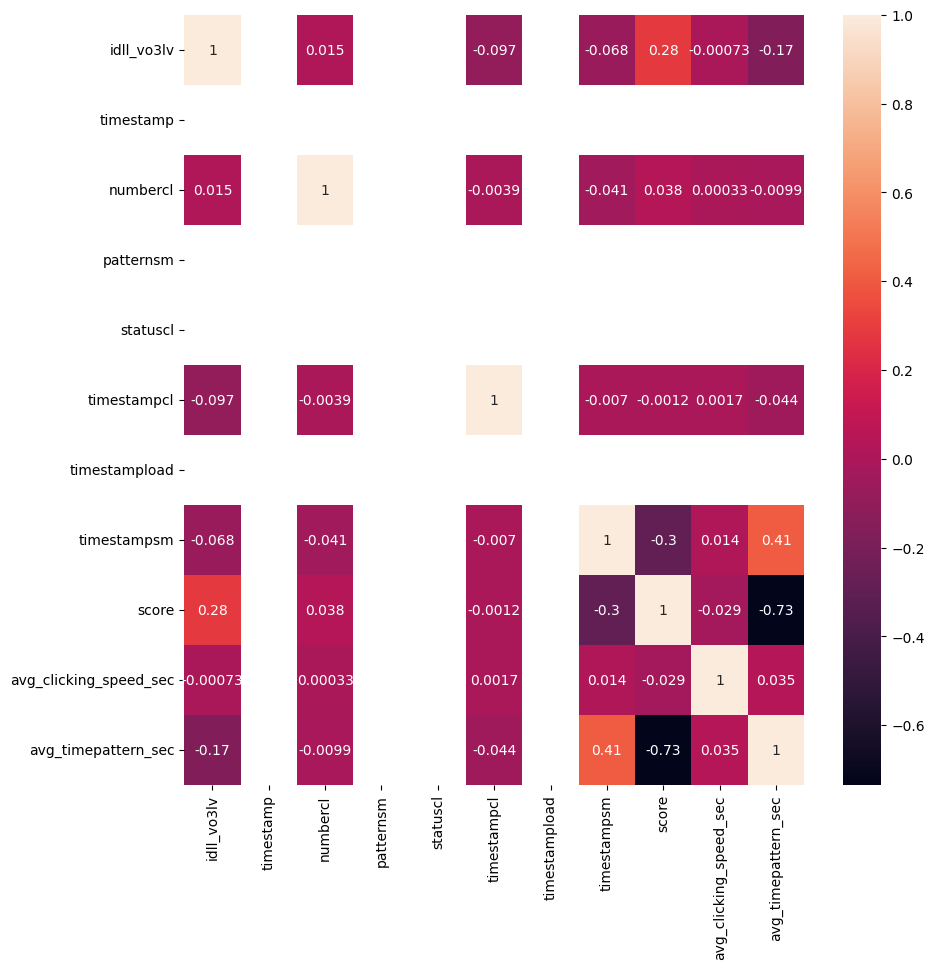

In [122]:
# Convert the DataFrame to numeric
df2 = df1.apply(pd.to_numeric, errors='coerce')

# Get correlation
correlation = df2.corr()

plt.figure(figsize=(10, 10)) # Set figure size
sns.heatmap(correlation, annot=True) # Plot heatmap with correlation values
plt.show()